In [2]:
from dataset import EEGDataset

dataset = EEGDataset('../data', limit=100, chunk_length=100, chunk_overlap=10, num_tokens=30)
print(dataset[0], len(dataset))

sample = dataset[0].unsqueeze(0).tile((3, 1, 1))
print(sample.shape)

torch.Size([4, 1693216])
tensor([[0.1111, 0.1118, 0.1118,  ..., 0.2179, 0.1334, 0.4000],
        [0.0760, 0.0769, 0.0768,  ..., 0.1184, 0.0548, 0.2657],
        [0.0395, 0.0405, 0.0400,  ..., 0.4000, 0.4000, 0.4000],
        [0.0685, 0.0702, 0.0696,  ..., 0.3511, 0.1597, 0.4000]]) 100
torch.Size([4, 1693216])
torch.Size([3, 4, 1693216])


In [3]:
sample = sample.unsqueeze(3)
sample.shape

torch.Size([3, 4, 1693216, 1])

In [5]:
import torch 

torch.nn.functional.unfold(sample, (250 * 2, 1), stride=(250 * 2, 1)).shape

torch.Size([3, 2000, 3386])

In [33]:
t = torch.arange(48, dtype=torch.float).reshape(1, 4, 12, 1)
torch.nn.functional.unfold(t, (4, 1), stride=(4, 1)).reshape(1, 4, 4, 3).transpose(1, 3).transpose(2, 3)

tensor([[[[ 0.,  1.,  2.,  3.],
          [12., 13., 14., 15.],
          [24., 25., 26., 27.],
          [36., 37., 38., 39.]],

         [[ 4.,  5.,  6.,  7.],
          [16., 17., 18., 19.],
          [28., 29., 30., 31.],
          [40., 41., 42., 43.]],

         [[ 8.,  9., 10., 11.],
          [20., 21., 22., 23.],
          [32., 33., 34., 35.],
          [44., 45., 46., 47.]]]])

In [29]:
t[0, :, :, 0]

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
        [36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.]])

In [52]:
def turn_into_patches(data, chunk_length, chunk_stride):
    assert len(data.shape) == 2 and data.shape[0] == 4, f'expected 2d tensor of shape (4, *), got {data.shape}'
    data_prep = data.unsqueeze(0).unsqueeze(3) # (1, 4, long, 1)
    chunked = torch.nn.functional.unfold(data_prep, kernel_size=(chunk_length, 1), stride=(chunk_stride, 1)) # (1, 4 * chunk_length, ~long // chunk_stride)
    assert len(chunked.shape) == 3 and chunked.shape[0] == 1 and chunked.shape[1] == 4 * chunk_length, f'expected (1, 4 * chunk_length, ~long // chunk_stride) got {chunked.shape}'
    chunked = chunked.reshape(1, 4, chunk_length, -1)
    print(chunked[0, :, :, 0].shape, data[:, :chunk_length].shape)
    assert (chunked[0, :, :, 0] == data[:, :chunk_length]).all(), "first chunk didn't match the beginning of data"
    return chunked
    
turn_into_patches(dataset[0], 500, 500).shape

torch.Size([4, 1693216])
torch.Size([4, 500]) torch.Size([4, 500])


torch.Size([1, 4, 500, 3386])

In [51]:
1693216 / 500

3386.432

In [43]:
dataset[0][:, :8]

torch.Size([4, 1693216])


tensor([[0.1111, 0.1118, 0.1118, 0.1118, 0.1123, 0.1113, 0.1118, 0.1117],
        [0.0760, 0.0769, 0.0768, 0.0765, 0.0769, 0.0762, 0.0769, 0.0768],
        [0.0395, 0.0405, 0.0400, 0.0391, 0.0394, 0.0397, 0.0409, 0.0402],
        [0.0685, 0.0702, 0.0696, 0.0680, 0.0683, 0.0685, 0.0702, 0.0696]])

In [4]:
from transformers import GPT2Config, GPT2Model

configuration = GPT2Config()
model = GPT2Model(configuration)

In [20]:
import torch

inp = torch.rand(8, 10, 768)
model.forward(inputs_embeds=inp, return_dict=True).last_hidden_state

odict_keys(['last_hidden_state', 'past_key_values'])

In [5]:
import torch

torch.arange(5).cumsum(0) / (torch.arange(5) + 1)

tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000])

torch.Size([2500])


/tmp/ipykernel_10000/227651399.py:16: UserWarning: shading value 'geraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  c = ax.pcolor(freqs, times, spec, shading='geraud',


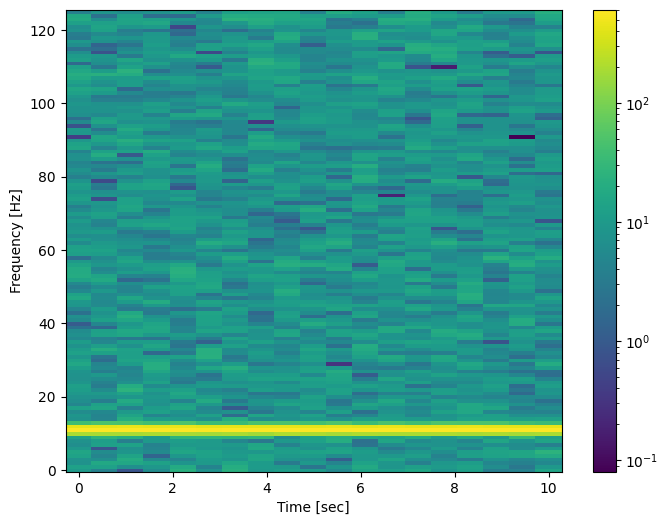

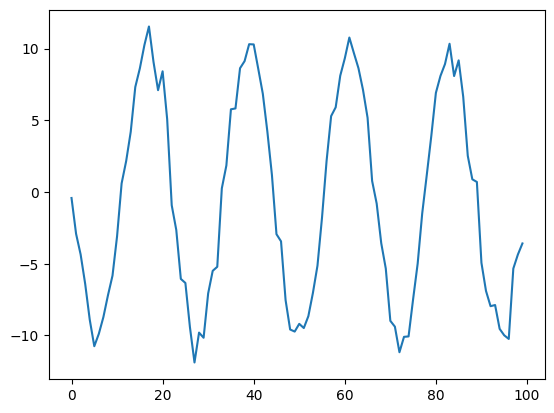

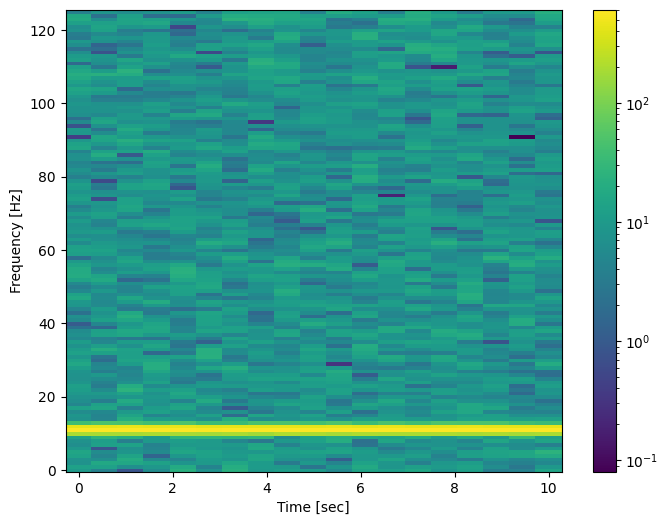

In [38]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from torch import stft
import torch

def plot_spec(data, n_fft=250, hop_length=125):
    assert len(data.shape) == 1, f"expected 1d input, got shape: {data.shape}"
    print(data.shape)
    spec = stft(data, n_fft=n_fft, window=torch.hann_window(n_fft), hop_length=hop_length, return_complex=False, center=False)
    spec = torch.sqrt((spec * spec).sum(2))
    
    freqs = torch.linspace(0, data.shape[0]/250, spec.shape[1])
    times = torch.linspace(0, 125, spec.shape[0])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolor(freqs, times, spec, shading='geraud',
               norm=LogNorm(vmin=spec.min(), vmax=spec.max()))
    fig.colorbar(c, ax=ax)
    
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    return fig
    
tnsr = torch.sin(6 * torch.arange(250 * 10)) * 10 + torch.randn(250 * 10) * 1
plt.plot(torch.arange(100), tnsr[:100])
plot_spec(tnsr)

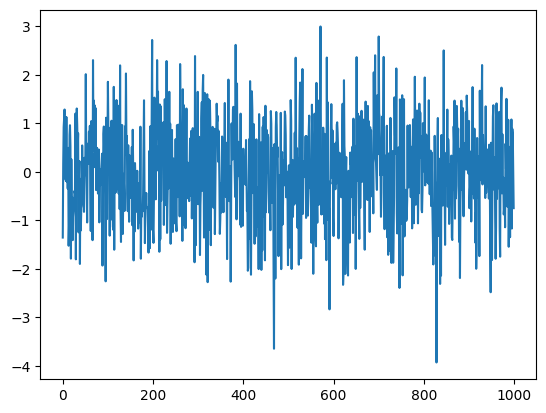

In [43]:
data = torch.randn(25000)
plt.plot(torch.arange(1000), data[:1000])

In [72]:
import torch 
from torch import nn


def make_pretrain_mask(batch_size, num_chunks, mask_prob, mask_length):
    mask = 1 * (torch.rand(batch_size, num_chunks) < mask_prob)
    # print("orig mask ", mask.tolist())
    mask[:, mask_length:] = mask[:, mask_length:] - mask[:, : -mask_length]
    # print("added_mask", mask.tolist())
    mask = mask.cumsum(1) > 0
    return mask

msk = make_pretrain_mask(2, 10, 0.3, 2)

In [77]:
tnsr = torch.rand(2, 10, 16)
msk_emb = torch.ones(16)

tnsr[msk] = msk_emb

In [81]:
msk[0]

tensor([False, False, False,  True,  True,  True, False,  True,  True, False])

In [3]:
from torch.nn import functional as F
import torch

a = torch.randn(100, 128)
b = torch.randn(100, 128)
F.cosine_similarity(a, b).shape

torch.Size([100])

In [7]:
torch.norm(a, 2, dim=1)

torch.Size([100])

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

def calc_loss(batch):
    batch_size, num_tokens, emb_size = batch['targets'].shape
    targets, preds = batch['targets'], batch['context_vectors']
    norm_targets = torch.norm(targets, 2, dim=2, keepdim=True) # batch_size, num_tokens
    norm_preds = torch.norm(preds, 2, dim=2, keepdim=True) # batch_size, num_tokens
    
    targets = targets / norm_targets
    preds = preds / norm_preds
    
    # targets = torch.cat([targets, 100 * torch.ones(batch_size, 5, emb_size, device=batch['targets'].device)], dim=1) 
    
    sim = preds @ targets.permute(0, 2, 1) # batch_size, num_tokens, num_tokens
    print(sim.shape, batch['mask'].shape)
    print(sim)
    sim = sim[batch['mask']] # num_masked, num_tokens -- for every masked prediction, logits  per all seq
    print('hui')
    labels = torch.tile(torch.arange(num_tokens), (batch_size, 1))
    labels = labels[batch['mask']].to(batch['targets'].device)
    print(sim, labels)
    loss = F.cross_entropy(sim, labels)
    
    return loss

batch = {
    'context_vectors': torch.tensor([[[1.0, 1.0], [1.0, -1.0], [-1.0, 1.0]]]),
    'targets': torch.tensor([[[1.0, 1.0], [1.0, -1.0], [-1.0, 1.0]]]),
    'mask': torch.tensor([[False, True, True]])
}

calc_loss(batch)

torch.Size([1, 3, 3]) torch.Size([1, 3])
tensor([[[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000, -1.0000],
         [ 0.0000, -1.0000,  1.0000]]])
hui
tensor([[ 0.0000,  1.0000, -1.0000],
        [ 0.0000, -1.0000,  1.0000]]) tensor([1, 2])


tensor(0.4076)